### Stochastic Gradient Descent (SGD)
- A simple & efficient training algorithm
- Not the *only* one out there. For example, `SGDClassifier(loss='log')` is equivalent to Logistic Regression fitted via SGD.

### [SGD Classification](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
- Accepts two input arrays: training data `X (#samples,#features)` and targets (labels) `y (#labels)`.

In [3]:
from sklearn.linear_model import SGDClassifier
X,y = [[0.0, 0.0], [1.0, 1.0]], [0.0, 1.0]

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=50)
clf.fit(X, y)
print(clf.coef_) # model params
print(clf.intercept_) # offset/bias
print(clf.predict([[2.0,2.0]])) # predicting new values

[[9.85221675 9.85221675]]
[-9.97004991]
[1.]


- `fit_intercept` tells the model whether to use an intercept (a biased hyperplane).
- `decision_function` (a method) returns the *signed distance to the hyperplane* (the dot product between the coefficients & the input sample - plus the intercept.)

In [4]:
clf.decision_function([[2.0, 2.0]])

array([29.43881708])

- `loss` sets the loss function for the model. options:
    - `loss="hinge"` - linear support vector machine
    - `loss="modified_huber"` - hinge loss (smoothed)
    - `loss="log"` - logistic regression
    
- Using log and modified_huber loss functions enables the `predict_proba` method - which returns a vector of probability estimates per sample x: $P(y|x)$

In [6]:
clf = SGDClassifier(loss="log", max_iter=25).fit(X, y)
clf.predict_proba([[1., 1.]])

array([[6.54276816e-07, 9.99999346e-01]])

- L1 & L2 norm penalties are set using `penalty`:
    - `penalty="l2"`: L2 norm penalty used on coef_.
    - `penalty="l1"`: L1 norm penalty used on coef_.
    - `penalty="elasticnet"`: convex combination of L1 & L2 norm penalties.
    
- The default is `penalty=l2"`.
- `l1_ratio` controls the convex L1/L2 penalty combination.

### Multiclass Classification
- Implemented with a one-vs-all (OVA) scheme. A binary classifier is trained on each of K classes vs all other (K-1) classes.
- The *confidence score* (the signed distance to the hyperplane) is found for each classifier; the class with the highest score is returned.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import SGDClassifier

In [17]:
iris = datasets.load_iris()
X,y,colors = iris.data[:,:2], iris.target, "bry"

# shuffle
idx = np.arange(X.shape[0])
np.random.seed(13); np.random.shuffle(idx)
X,y = X[idx],y[idx]

# standardize
mean = X.mean(axis=0)
std  = X.std(axis=0)
X    = (X-mean)/std

In [18]:
h = .02  # step size in the mesh

clf = SGDClassifier(alpha=0.001, max_iter=100).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

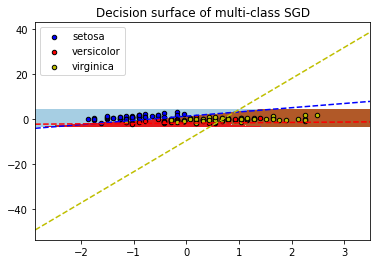

In [19]:
Z = clf.predict(np.c_[xx.ravel(), 
                      yy.ravel()])

Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], 
                X[idx, 1], 
                c=color, label=iris.target_names[i],
                cmap=plt.cm.Paired, edgecolor='black', s=20)
    
plt.title("Decision surface of multi-class SGD")

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_

def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color)

for i, color in zip(clf.classes_, colors):
    plot_hyperplane(i, color)

plt.legend(); plt.show()

### Weighted Classification
- SGDClassifier supports weighted classes (via `class_weight`) and instances (via `sample_weight`).

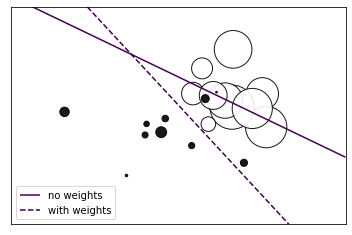

In [23]:
from sklearn import linear_model

np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], 
          np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10

sample_weight       = 100 * np.abs(np.random.randn(20))
sample_weight[:10] *= 10 # assign more weight to last 10 samples

xx, yy = np.meshgrid(np.linspace(-4, 5, 500), 
                     np.linspace(-4, 5, 500))
plt.figure()
plt.scatter(X[:, 0], 
            X[:, 1], 
            c=y, s=sample_weight, alpha=0.9,
            cmap=plt.cm.bone, edgecolor='black')

# fit the unweighted model
clf = linear_model.SGDClassifier(alpha=0.01, max_iter=100)
clf.fit(X, y)
Z = clf.decision_function(np.c_[xx.ravel(), 
                                yy.ravel()])
Z = Z.reshape(xx.shape)
no_weights = plt.contour(xx, yy, Z, 
                         levels=[0], linestyles=['solid'])

# fit the weighted model
clf = linear_model.SGDClassifier(alpha=0.01, max_iter=100)
clf.fit(X, y, sample_weight=sample_weight)
Z = clf.decision_function(np.c_[xx.ravel(), 
                                yy.ravel()])
Z = Z.reshape(xx.shape)
samples_weights = plt.contour(xx, yy, Z, 
                              levels=[0], linestyles=['dashed'])

plt.legend([no_weights.collections[0], 
            samples_weights.collections[0]],
           ["no weights", "with weights"], loc="lower left")

plt.xticks(()); plt.yticks(()); plt.show()

### Averaged SGD
- SGDClassifier supports averaged SGD (ASGD) via `average=True`.
- ASGD computes the same updates as SGD, except that `coef_` is set to the **average** coefficient values across all updates. (The same distinction happens with `intercept_`.)
- ASGD can result in accelerated learning rates = learning rate speedups.

### Example: Solver comparison
- compares SGD, ASGD, Perceptron, Passive-Aggressive I/II, SAG

In [24]:
from sklearn.model_selection import train_test_split as TTS
from sklearn.linear_model import SGDClassifier as SGC
from sklearn.linear_model import Perceptron as PERCEPT
from sklearn.linear_model import PassiveAggressiveClassifier as PAC
from sklearn.linear_model import LogisticRegression as LR


In [25]:
heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 20
X, y = datasets.load_digits(return_X_y=True)

In [26]:
classifiers = [
    ("SGD",           SGC(max_iter=100)),
    ("ASGD",          SGC(average=True)),
    ("Perceptron",    PERCEPT()),
    ("Pasv-Agrsv I",  PAC(loss='hinge', C=1.0, tol=1e-4)),
    ("Pasv-Agrsv II", PAC(loss='squared_hinge', C=1.0, tol=1e-4)),
    ("SAG",           LR(solver='sag', tol=1e-1, C=1.e4 / X.shape[0]))
]

training SGD
training ASGD
training Perceptron
training Pasv-Agrsv I
training Pasv-Agrsv II
training SAG


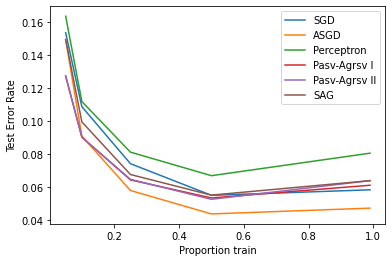

In [27]:
xx = 1. - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = \
                TTS(X, y, test_size=i, random_state=rng)
            
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()

### [SGD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor)
- Implementation that supports various loss functions & penalties
- Well suited for regression problems with >10K training samples
- Loss function options:
    - `loss="squared_loss"`: ordinary least squares regression
    - `loss="huber"`: huber loss for robust regression
    - `loss="epsilon_insensitive`: linear support vector regression
- `penalty` controls regularization (same options as in classification)
- Averaged SGD (ASGD) is supported.
- Stochastic Average Gradient (SAG) is supported.

In [28]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y   = rng.randn(n_samples)
X   = rng.randn(n_samples, n_features)

# Always scale inputs. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

### SGD & Sparse Data
- Built-in support using data from scipy.sparse.
- For max efficiency, use CSR matrix format (scipy.sparse.csr_matrix)

### Computational Complexity
- Major advantage of SGD: near-linear relationship with #training samples

### Stopping & Convergence
- SGD Classifier & Regressor methods support two ways to stop when a given level of convergence is reached:
    - `early_stopping=True`: stopping criteria is based on the prediction score (`score`) found on the validation set.
    - `early_stopping=False`: model is fitted on entire input dataset. Stopping is based on the objective function found on the training dataset.
- Stopping criteria is evaluated once per epoch. The algorithm stops when the criterion does not improve by `n_iter_no_change` consecutive times.
- The algorithm stops regardless after a max #iterations `max_iter`.

### Tips
- **scale your data**. Easily done using `StandardScaler`.
- Find a reasonable regularization term $\alpha$ with automatic parameter search (GridSearchCV or RandomizedSearchCV). Consider using a range similar to 10.0**-np.arange(1,7)
- SGD typically converges after ~10^6 training samples.
- If applying SGD to extracted features (for example, using PCA), *consider scaling feature values by a constant `c` such that the average L2 norm of the training data equals one.*
